# 层归一化
在本教程中，您将编写一个高性能的层归一化内核，其运行速度快于 PyTorch 实现。
通过这样做，您将了解：
- 在 Triton 中实现反向传播。
- 在 Triton 中实现并行归约。

## 动机
LayerNorm 操作符首次在 [BA2016] 中被引入，作为提高序列模型（例如，Transformers）或小批量神经网络性能的一种方法。它以向量 `x` 作为输入，并生成一个形状相同的输出向量 `y`。归一化通过减去均值并除以 `x` 的标准差来执行。在归一化之后，应用一个可学习的线性变换，权重为 `w`，偏置为 `b`。前向传播可以表示如下：

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>y</mi>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mi>x</mi>
      <mo>&#x2212;</mo>
      <mtext>E</mtext>
      <mo stretchy="false">[</mo>
      <mi>x</mi>
      <mo stretchy="false">]</mo>
    </mrow>
    <msqrt>
      <mtext>Var</mtext>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo stretchy="false">)</mo>
      <mo>+</mo>
      <mi>&#x3F5;</mi>
    </msqrt>
  </mfrac>
  <mo>&#x2217;</mo>
  <mi>w</mi>
  <mo>+</mo>
  <mi>b</mi>
</math>

其中 
<math>
<mi>&#x3F5;</mi>
</math>
是为数值稳定性而添加到分母的小常数。让我们首先看看前向传播的实现。


In [ ]:
import tabulate
import torch
import triton
import triton.language as tl

# ---
# 整体概览
# 这段代码首先尝试导入 NVIDIA 的 Apex 库。Apex 提供了包括高度优化的 LayerNorm 实现在内的多种工具。
# 这里的目的是检查 Apex 是否存在，以便后续可能将其作为性能对比的另一个“黄金标准”。
# 这段代码本身不依赖 Apex 来运行，只是做一个环境检查。
# ---
try:
    # Apex 库 (https://github.com/NVIDIA/apex) 并非通过 PyPi 安装，
    # 因此不应被添加到项目的常规依赖中。
    import apex
    HAS_APEX = True
except ModuleNotFoundError:
    HAS_APEX = False

# 动态检测并设置当前可用的 GPU 设备。
DEVICE = triton.runtime.driver.active.get_active_torch_device()


# ---
# 整体概览
# 这是一个为 Layer Normalization 前向传播过程编写的、高性能的“融合” GPU 核函数。
# LayerNorm 对一个张量的特定维度（通常是最后一个维度）进行归一化，使其均值为0，方差为1，
# 然后再通过一个可学习的仿射变换（乘以权重 w，加上偏置 b）进行缩放和平移。
#
# 这个内核的“融合”特性是其高性能的关键。它将 LayerNorm 的所有计算步骤：
# 1. 计算均值 (Mean)
# 2. 计算方差 (Variance)
# 3. 归一化 (Normalize)
# 4. 仿射变换 (Affine Transformation)
# ...全部合并到这一个单独的内核中。这意味着所有的中间计算都在 GPU 的高速缓存（SRAM）中完成，
# 极大地减少了对慢速全局内存（DRAM）的读写次数，从而实现了性能的大幅提升。
#
# 该内核的并行策略是：每个程序实例（Program）负责处理输入张量 `X` 中的一整行。
# ---
@triton.jit
def _layer_norm_fwd_fused(
    X,          # 指向输入张量的指针。
    Y,          # 指向输出张量的指针。
    W,          # 指向权重张量 `weight` 的指针。
    B,          # 指向偏置张量 `bias` 的指针。
    Mean,       # 指向用于保存均值的张量的指针（为反向传播准备）。
    Rstd,       # 指向用于保存标准差倒数（1/std）的张量的指针（为反向传播准备）。
    stride,     # 步长：在内存中从一行移动到下一行需要跳过的元素数量。
    N,          # `X` 的列数，即需要进行归一化的维度的大小。
    eps,        # 一个很小的数，用于防止在计算标准差时除以零。
    BLOCK_SIZE: tl.constexpr, # 每个程序块处理的列数，是一个编译期常量。
):
    # --- 1. 程序ID到行的映射 ---
    # 将程序ID直接映射到它应该处理的行号。
    row = tl.program_id(0)
    # 通过一次性的指针运算，将 X 和 Y 的基地址直接移动到当前程序负责处理的行的开头。
    # 这是一个高效的技巧，避免了在后续的循环中反复计算行起始地址。
    Y += row * stride
    X += row * stride

    # --- 2. 计算均值 (Mean) ---
    # 由于一行（N个元素）可能很长，无法一次性加载到SRAM，所以采用分块（Tiling）的方式处理。
    # 内核会分多次、每次处理 BLOCK_SIZE 个元素来遍历整行。
    # `_mean` 是一个在SRAM中分配的、用于分块累加的向量累加器。
    _mean = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    # 循环遍历当前行，步长为 BLOCK_SIZE。
    for off in range(0, N, BLOCK_SIZE):
        # 计算当前块的列偏移量。
        cols = off + tl.arange(0, BLOCK_SIZE)
        # 安全地加载当前块的数据，使用掩码处理行尾不足一个 BLOCK_SIZE 的情况。
        # 将数据转换为 float32 以保证累加的精度。
        a = tl.load(X + cols, mask=cols < N, other=0.).to(tl.float32)
        # 将加载的数据块累加到 `_mean` 向量中。
        _mean += a
    # 在所有块都处理完毕后，对SRAM中的 `_mean` 向量进行最终求和（Reduction），
    # 然后除以总列数 N，得到这一行的精确均值。
    mean = tl.sum(_mean, axis=0) / N

    # --- 3. 计算方差 (Variance) ---
    # 计算方差的逻辑与计算均值非常相似，同样采用分块累加的方式。
    _var = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    # 再次循环遍历当前行。注意：这里重新从DRAM加载了数据。
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        x = tl.load(X + cols, mask=cols < N, other=0.).to(tl.float32)
        # 计算 (x - mean)。
        x = tl.where(cols < N, x - mean, 0.)
        # 累加平方差 (x - mean)^2。
        _var += x * x
    # 对SRAM中的 `_var` 向量进行最终求和，得到方差。
    var = tl.sum(_var, axis=0) / N
    # 计算标准差的倒数，`eps` 用于防止 `var` 为零。
    rstd = 1 / tl.sqrt(var + eps)

    # --- 4. 保存均值和标准差倒数（为反向传播准备） ---
    # 将为当前行计算出的均值和标准差倒数写回到DRAM中对应的位置。
    tl.store(Mean + row, mean)
    tl.store(Rstd + row, rstd)

    # --- 5. 归一化、仿射变换并写回输出 ---
    # 第三次循环遍历当前行，以应用归一化和线性变换。
    for off in range(0, N, BLOCK_SIZE):
        cols = off + tl.arange(0, BLOCK_SIZE)
        mask = cols < N
        # 加载权重 `w` 和偏置 `b` 的对应分块。
        w = tl.load(W + cols, mask=mask)
        b = tl.load(B + cols, mask=mask)
        # 再次加载输入数据 `x` 的分块。
        x = tl.load(X + cols, mask=mask, other=0.).to(tl.float32)
        # 执行归一化操作: (x - mean) * (1 / std)。
        x_hat = (x - mean) * rstd
        # 应用可学习的仿射变换: y = x_hat * w + b。
        y = x_hat * w + b
        # 将最终计算好的输出块 `y` 写回到DRAM中的 `Y` 张量。
        tl.store(Y + cols, y, mask=mask)

## 反向传播

层归一化操作符的反向传播比前向传播稍微复杂一些。设 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mover>
    <mi>x</mi>
    <mo stretchy="false">^</mo>
  </mover>
</math>
 为线性变换前的归一化输入 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mfrac>
    <mrow>
      <mi>x</mi>
      <mo>&#x2212;</mo>
      <mtext>E</mtext>
      <mo stretchy="false">[</mo>
      <mi>x</mi>
      <mo stretchy="false">]</mo>
    </mrow>
    <msqrt>
      <mtext>Var</mtext>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo stretchy="false">)</mo>
      <mo>+</mo>
      <mi>&#x3F5;</mi>
    </msqrt>
  </mfrac>
</math>
，则 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>x</mi>
</math>
的向量-雅可比乘积 (VJP) 
<math xmlns="http://www.w3.org/1998/Math/MathML">
<mi mathvariant="normal">&#x2207;</mi>
<mrow data-mjx-texclass="ORD">
    <mi>x</mi>
</mrow>
</math>
为：

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi mathvariant="normal">&#x2207;</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>x</mi>
    </mrow>
  </msub>
  <mo>=</mo>
  <mfrac>
    <mn>1</mn>
    <mi>&#x3C3;</mi>
  </mfrac>
  <mrow data-mjx-texclass="ORD">
    <mo minsize="1.623em" maxsize="1.623em">(</mo>
  </mrow>
  <msub>
    <mi mathvariant="normal">&#x2207;</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>y</mi>
    </mrow>
  </msub>
  <mo>&#x2299;</mo>
  <mi>w</mi>
  <mo>&#x2212;</mo>
  <munder>
    <mrow data-mjx-texclass="OP">
      <munder>
        <mrow>
          <mrow data-mjx-texclass="ORD">
            <mo minsize="1.2em" maxsize="1.2em">(</mo>
          </mrow>
          <mfrac>
            <mn>1</mn>
            <mi>N</mi>
          </mfrac>
          <mrow data-mjx-texclass="ORD">
            <mover>
              <mi>x</mi>
              <mo stretchy="false">^</mo>
            </mover>
          </mrow>
          <mo>&#x22C5;</mo>
          <mo stretchy="false">(</mo>
          <msub>
            <mi mathvariant="normal">&#x2207;</mi>
            <mrow data-mjx-texclass="ORD">
              <mi>y</mi>
            </mrow>
          </msub>
          <mo>&#x2299;</mo>
          <mi>w</mi>
          <mo stretchy="false">)</mo>
          <mrow data-mjx-texclass="ORD">
            <mo minsize="1.2em" maxsize="1.2em">)</mo>
          </mrow>
        </mrow>
        <mo>&#x23DF;</mo>
      </munder>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <msub>
        <mi>c</mi>
        <mn>1</mn>
      </msub>
    </mrow>
  </munder>
  <mo>&#x2299;</mo>
  <mrow data-mjx-texclass="ORD">
    <mover>
      <mi>x</mi>
      <mo stretchy="false">^</mo>
    </mover>
  </mrow>
  <mo>&#x2212;</mo>
  <munder>
    <mrow data-mjx-texclass="OP">
      <munder>
        <mrow>
          <mfrac>
            <mn>1</mn>
            <mi>N</mi>
          </mfrac>
          <msub>
            <mi mathvariant="normal">&#x2207;</mi>
            <mrow data-mjx-texclass="ORD">
              <mi>y</mi>
            </mrow>
          </msub>
          <mo>&#x22C5;</mo>
          <mi>w</mi>
        </mrow>
        <mo>&#x23DF;</mo>
      </munder>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <msub>
        <mi>c</mi>
        <mn>2</mn>
      </msub>
    </mrow>
  </munder>
  <mrow data-mjx-texclass="ORD">
    <mo minsize="1.623em" maxsize="1.623em">)</mo>
  </mrow>
</math>

where 
 denotes the element-wise multiplication,

 denotes the dot product, and 
 is the standard deviation. 
 and 
 are intermediate constants that improve the readability of the following implementation.

其中
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo>&#x2299;</mo>
</math>
表示逐元素乘法，
<math xmlns="http://www.w3.org/1998/Math/MathML">
 <mo>&#x22C5;</mo> 
</math>
表示点积，
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>&#x3C3;</mi>
</math>
是标准差。
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
        <mi>c</mi>
        <mn>1</mn>
      </msub>
</math>
和
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
        <mi>c</mi>
        <mn>2</mn>
      </msub>
</math>
是中间常数，旨在提高以下实现的可读性。

对于权重
<math xmlns="http://www.w3.org/1998/Math/MathML">
<mi>w</mi>
</math>
和偏置
<math xmlns="http://www.w3.org/1998/Math/MathML">
<mi>b</mi>
</math>
 ，VJP
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x2207;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi>w</mi>
  </mrow>
</math>
和
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x2207;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi>b</mi>
  </mrow>
</math>
更加简单：

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi mathvariant="normal">&#x2207;</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>w</mi>
    </mrow>
  </msub>
  <mo>=</mo>
  <msub>
    <mi mathvariant="normal">&#x2207;</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>y</mi>
    </mrow>
  </msub>
  <mo>&#x2299;</mo>
  <mrow data-mjx-texclass="ORD">
    <mover>
      <mi>x</mi>
      <mo stretchy="false">^</mo>
    </mover>
  </mrow>
  <mstyle scriptlevel="0">
    <mspace width="1em"></mspace>
  </mstyle>
  <mtext>and</mtext>
  <mstyle scriptlevel="0">
    <mspace width="1em"></mspace>
  </mstyle>
  <msub>
    <mi mathvariant="normal">&#x2207;</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>b</mi>
    </mrow>
  </msub>
  <mo>=</mo>
  <msub>
    <mi mathvariant="normal">&#x2207;</mi>
    <mrow data-mjx-texclass="ORD">
      <mi>y</mi>
    </mrow>
  </msub>
</math>

由于在同一批次中的所有行使用相同的权重
<math xmlns="http://www.w3.org/1998/Math/MathML">
<mi>w</mi>
</math>
和偏置
<math xmlns="http://www.w3.org/1998/Math/MathML">
<mi>b</mi>
</math>
，因此它们的梯度需要相加。为了高效地执行此步骤，我们使用并行归约策略：每个内核实例在某些行中将部分
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x2207;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi>w</mi>
  </mrow>
</math>
和
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x2207;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi>b</mi>
  </mrow>
</math>
累积到 `GROUP_SIZE_M` 个独立缓冲区中的一个。这些缓冲区保留在 L2 缓存中，然后通过另一个函数进一步归约，以计算实际的 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x2207;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi>w</mi>
  </mrow>
</math>
和
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x2207;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi>b</mi>
  </mrow>
</math>
。

设输入行的数量为 `M = 4` 和 `GROUP_SIZE_M = 2` ，以下是
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x2207;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi>w</mi>
  </mrow>
</math>
的并行归约策略示意图（为简洁起见，
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x2207;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi>b</mi>
  </mrow>
</math>
被省略）：
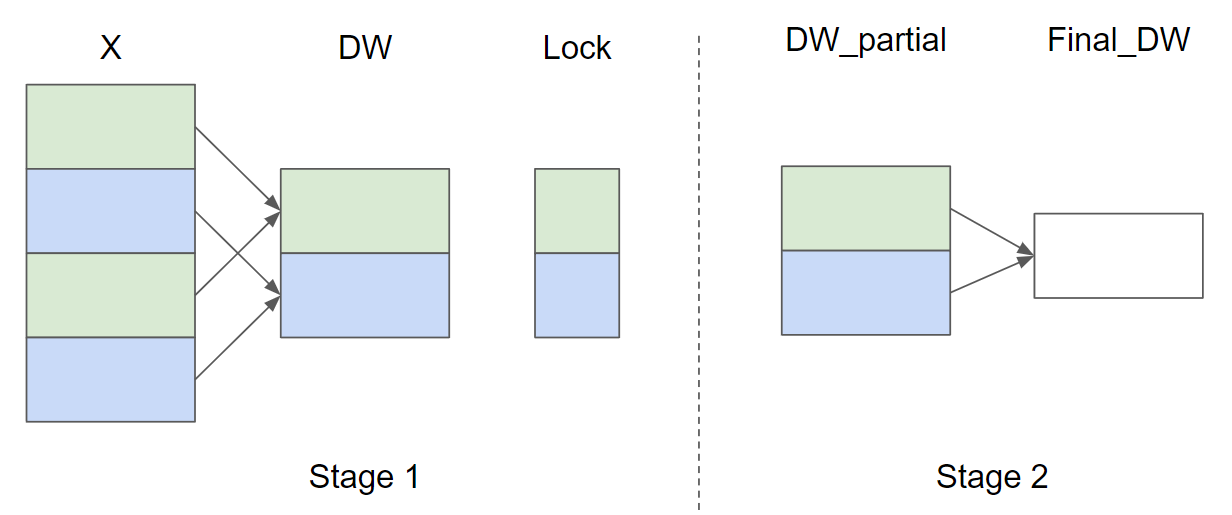

在阶段 1 中，具有相同颜色的 X 的行共享同一个缓冲区，因此使用锁以确保在任何时候只有一个内核实例可以写入该缓冲区。在阶段 2 中，缓冲区进一步减少以计算最终的 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x2207;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi>w</mi>
  </mrow>
</math>
和
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi mathvariant="normal">&#x2207;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi>b</mi>
  </mrow>
</math>
。在以下实现中，阶段 1 由函数 _layer_norm_bwd_dx_fused 实现，阶段 2 由函数 _layer_norm_bwd_dwdb 实现。

In [ ]:
# ---
# 整体概览
# 这是为 Layer Normalization 反向传播过程设计的第一阶段的“融合” GPU 核函数。
# 它的核心职责有两个：
# 1. 计算输入梯度 (dX): 对于每一行，它完整地计算出关于输入 `X` 的梯度 `dX`。
# 2. 计算部分梯度和 (Partial dW/dB): 它还计算关于权重 `W` 和偏置 `B` 的梯度。但由于多个行（由不同的程序实例并行处理）
#    的 `dW` 和 `dB` 需要被累加起来，为了避免数据竞争，这个内核只计算出一个“部分和 (partial sum)”。
#    它使用原子操作（atomic operations）将不同行的计算结果安全地累加到一个共享的中间存储区。
#
# 这种两阶段的方法（计算部分和 -> 最终求和）是并行计算中一种常见且高效的归约（Reduction）策略。
#
# 该内核的并行策略是：每个程序实例（Program）负责处理输入张量 `X` 中的一整行。
# ---
@triton.jit
def _layer_norm_bwd_dx_fused(DX,  # 指向输入梯度 dX 的指针。
                             DY,  # 指向输出梯度 dY 的指针。
                             DW,  # 指向 dW 的“部分和”存储区的指针。
                             DB,  # 指向 dB 的“部分和”存储区的指针。
                             X,   # 指向原始输入 X 的指针。
                             W,   # 指向权重 W 的指针。
                             Mean, # 指向由前向传播计算出的均值的指针。
                             Rstd, # 指向由前向传播计算出的标准差倒数(1/std)的指针。
                             Lock, # 指向一个锁数组的指针，用于同步并行归约。
                             stride,  # 步长。
                             N,       # X 的列数。
                             GROUP_SIZE_M: tl.constexpr, # 用于并行归约的分组大小。
                             BLOCK_SIZE_N: tl.constexpr): # 每个程序块处理的列数。
    # --- 1. 程序ID到行的映射 ---
    # 将程序ID直接映射到它应该处理的行号。
    row = tl.program_id(0)
    # 创建当前块的列偏移量。
    cols = tl.arange(0, BLOCK_SIZE_N)
    mask = cols < N
    # 将 X, DY, DX 的基地址直接移动到当前程序负责处理的行的开头。
    X += row * stride
    DY += row * stride
    DX += row * stride

    # --- 2. 为并行归约设置指针 ---
    # 计算当前行所属的锁ID。多个行将共享同一个锁，以对它们的 dW/dB 进行归约。
    lock_id = row % GROUP_SIZE_M
    Lock += lock_id
    # `Count` 指针指向锁旁边的计数器，用于实现一个安全的累加逻辑。
    Count = Lock + GROUP_SIZE_M
    # 将 dW 和 dB 的指针偏移到当前锁对应的部分和存储区域。
    DW = DW + lock_id * N + cols
    DB = DB + lock_id * N + cols

    # --- 3. 加载数据到 SRAM ---
    # 从 DRAM 加载计算所需的所有数据。
    x = tl.load(X + cols, mask=mask, other=0).to(tl.float32)
    dy = tl.load(DY + cols, mask=mask, other=0).to(tl.float32)
    w = tl.load(W + cols, mask=mask).to(tl.float32)
    mean = tl.load(Mean + row)
    rstd = tl.load(Rstd + row)

    # --- 4. 计算输入梯度 dX ---
    # 这是 LayerNorm 反向传播的核心数学公式。
    # 所有计算都在高速的 SRAM 中完成。
    xhat = (x - mean) * rstd
    wdy = w * dy
    xhat = tl.where(mask, xhat, 0.) # 应用掩码确保边界外的元素不参与计算
    wdy = tl.where(mask, wdy, 0.)
    c1 = tl.sum(xhat * wdy, axis=0) / N
    c2 = tl.sum(wdy, axis=0) / N
    dx = (wdy - (xhat * c1 + c2)) * rstd
    # 将计算好的 dX 写回到 DRAM。
    tl.store(DX + cols, dx, mask=mask)

    # --- 5. 使用原子操作累加 dW/dB 的部分和 ---
    # 计算当前行贡献的 dW 和 dB。
    partial_dw = (dy * xhat).to(w.dtype)
    partial_db = (dy).to(w.dtype)
    # 使用一个自旋锁（spin-lock）来等待获取锁。
    # `tl.atomic_cas` (Compare-And-Swap) 会尝试将 `Lock` 的值从 0 原子地交换为 1。
    # 如果交换成功（返回旧值0），则当前程序获得锁，退出循环；否则继续循环等待。
    while tl.atomic_cas(Lock, 0, 1) == 1:
        pass
    # 获得锁后，读取计数器 `count`。
    count = tl.load(Count)
    # 如果是第一个写入该区域的程序，则直接存储，并更新计数器为1。
    if count == 0:
        tl.atomic_xchg(Count, 1)
    # 如果不是第一个，则先加载已有的部分和，然后累加上自己的部分和。
    else:
        partial_dw += tl.load(DW, mask=mask)
        partial_db += tl.load(DB, mask=mask)
    # 将更新后的部分和写回。
    tl.store(DW, partial_dw, mask=mask)
    tl.store(DB, partial_db, mask=mask)

    # 这是一个调试用的屏障，在实际发布代码中可以移除。
    # 它确保在释放锁之前，组内的所有线程都已完成它们的存储操作。
    tl.debug_barrier()

    # 释放锁，将锁的值原子地交换回 0，以便其他程序可以获取它。
    tl.atomic_xchg(Lock, 0)

# ---
# 整体概览
# 这是为 Layer Normalization 反向传播过程设计的第二阶段的 GPU 核函数。
# 它的职责非常专一：将第一个内核 `_layer_norm_bwd_dx_fused` 计算出的、
# 存储在中间区域的 dW 和 dB 的“部分和”进行最终的求和（Reduction），
# 从而得到最终的、完整的权重梯度 `FINAL_DW` 和偏置梯度 `FINAL_DB`。
#
# 该内核的并行策略是：每个程序实例（Program）负责计算最终梯度张量中的一个列块（BLOCK_SIZE_N 列）。
# ---
@triton.jit
def _layer_norm_bwd_dwdb(DW,       # 指向 dW 的“部分和”存储区的指针。
                         DB,       # 指向 dB 的“部分和”存储区的指针。
                         FINAL_DW, # 指向最终 dW 输出位置的指针。
                         FINAL_DB, # 指向最终 dB 输出位置的指针。
                         M,        # 部分和的组数（即 GROUP_SIZE_M）。
                         N,        # 列数。
                         BLOCK_SIZE_M: tl.constexpr,
                         BLOCK_SIZE_N: tl.constexpr):
    # --- 1. 程序ID到列的映射 ---
    # 获取当前程序ID。
    pid = tl.program_id(0)
    # 计算当前程序负责处理的列的偏移量。
    cols = pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    
    # --- 2. 累加部分和 ---
    # 初始化用于累加的 SRAM 累加器。
    dw = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    db = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    # 循环遍历所有 M 个部分和组。
    for i in range(0, M, BLOCK_SIZE_M):
        rows = i + tl.arange(0, BLOCK_SIZE_M)
        # 创建一个2D掩码，以处理 M 或 N 不是块大小整数倍的边界情况。
        mask = (rows[:, None] < M) & (cols[None, :] < N)
        # 计算要加载的部分和在内存中的偏移量。
        offs = rows[:, None] * N + cols[None, :]
        # 从 DRAM 加载部分和数据块，并累加到 SRAM 累加器中。
        dw += tl.load(DW + offs, mask=mask, other=0.)
        db += tl.load(DB + offs, mask=mask, other=0.)
        
    # --- 3. 最终求和并写回 ---
    # 对 SRAM 累加器 `dw` 沿着行方向（axis=0）求和，得到最终的 dW 列块。
    sum_dw = tl.sum(dw, axis=0)
    # 对 `db` 做同样的操作。
    sum_db = tl.sum(db, axis=0)
    # 将最终计算出的梯度列块写回到 DRAM 中的最终位置。
    tl.store(FINAL_DW + cols, sum_dw, mask=cols < N)
    tl.store(FINAL_DB + cols, sum_db, mask=cols < N)

## 基准测试

我们现在可以将我们的内核性能与 PyTorch 的性能进行比较。在这里，我们关注每个特征小于 64KB 的输入。具体来说，可以设置 'mode': 'backward' 来基准测试反向传播。

In [ ]:
# ---
# 整体概览
# 这是一个自定义的 PyTorch 自动微分函数，它将我们前面编写的 Triton 内核封装起来。
# 通过继承 `torch.autograd.Function`，我们可以为 Layer Normalization 操作定义一个自定义的
# 前向传播（`forward`）和反向传播（`backward`）过程。
# 这使得我们的 Triton 实现可以无缝地集成到 PyTorch 的生态系统中，用户可以像调用任何
# 普通的 PyTorch 函数一样调用它，并让 PyTorch 自动处理梯度计算。
# ---
class LayerNorm(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, normalized_shape, weight, bias, eps):
        # --- 前向传播 ---
        # `ctx` 是一个上下文对象，用于保存张量和参数，以便在反向传播时使用。

        # 1. 准备工作
        # 预分配用于存储结果的输出张量。
        y = torch.empty_like(x)
        # 将输入张量重塑为 2D，以便我们的内核可以按行处理。
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        # 为均值和标准差倒数分配存储空间。
        mean = torch.empty((M, ), dtype=torch.float32, device=x.device)
        rstd = torch.empty((M, ), dtype=torch.float32, device=x.device)

        # 2. 内核启动配置（启发式）
        # 设置一个特征维度的上限，以决定是否使用融合内核。
        MAX_FUSED_SIZE = 65536 // x.element_size()
        # 确定内核的块大小（BLOCK_SIZE）。
        BLOCK_SIZE = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
        if N > BLOCK_SIZE:
            raise RuntimeError("This layer norm doesn't support feature dim >= 64KB.")
        # 根据块大小启发式地设置 Warp 的数量，这是一个性能调优参数。
        num_warps = min(max(BLOCK_SIZE // 256, 1), 8)

        # 3. 启动前向传播内核
        # 定义启动网格大小，每个程序实例处理一行，所以总共有 M 个实例。
        # 调用我们之前定义的 `_layer_norm_fwd_fused` 内核。
        _layer_norm_fwd_fused[(M, )](
            x_arg, y, weight, bias, mean, rstd,  # 张量和指针
            x_arg.stride(0), N, eps,             # 其他参数
            BLOCK_SIZE=BLOCK_SIZE, num_warps=num_warps, num_ctas=1)

        # 4. 保存信息以备反向传播使用
        # 使用 `ctx.save_for_backward` 保存所有在反向传播中需要的张量。
        ctx.save_for_backward(x, weight, bias, mean, rstd)
        # 将一些非张量的参数直接保存在 `ctx` 对象上。
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.num_warps = num_warps
        ctx.eps = eps
        return y

    @staticmethod
    def backward(ctx, dy):
        # --- 反向传播 ---
        # `dy` 是来自上一层的、关于输出 `y` 的梯度。

        # 1. 准备工作
        # 从上下文中恢复在前向传播时保存的张量和参数。
        x, w, b, m, v = ctx.saved_tensors
        # 根据特征维度 N 的大小，启发式地设置用于并行归约的组大小。
        N = w.shape[0]
        GROUP_SIZE_M = 64
        if N <= 8192: GROUP_SIZE_M = 96
        if N <= 4096: GROUP_SIZE_M = 128
        if N <= 1024: GROUP_SIZE_M = 256
        
        # 2. 分配梯度和中间结果的存储空间
        # 为原子操作分配锁和计数器。
        locks = torch.zeros(2 * GROUP_SIZE_M, dtype=torch.int32, device=w.device)
        # 为 dW 和 dB 的“部分和”分配中间存储区。
        _dw = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        _db = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        # 为最终的 dW 和 dB 分配存储空间。
        dw = torch.empty((N, ), dtype=w.dtype, device=w.device)
        db = torch.empty((N, ), dtype=w.dtype, device=w.device)
        # 为输入梯度 dX 分配存储空间。
        dx = torch.empty_like(dy)
        
        # 3. 启动反向传播内核
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        # 启动第一阶段内核 `_layer_norm_bwd_dx_fused`。
        # 这个内核会计算出完整的 dX，以及 dW/dB 的部分和 `_dw`/`_db`。
        _layer_norm_bwd_dx_fused[(M, )](
            dx, dy, _dw, _db, x, w, m, v, locks,
            x_arg.stride(0), N,
            BLOCK_SIZE_N=ctx.BLOCK_SIZE,
            GROUP_SIZE_M=GROUP_SIZE_M,
            num_warps=ctx.num_warps)
        
        # 定义第二阶段内核的启动网格。
        grid = lambda meta: (triton.cdiv(N, meta['BLOCK_SIZE_N']), )
        # 启动第二阶段内核 `_layer_norm_bwd_dwdb`。
        # 这个内核会将 `_dw` 和 `_db` 的部分和进行最终的求和，得到最终的 `dw` 和 `db`。
        _layer_norm_bwd_dwdb[grid](
            _dw, _db, dw, db, min(GROUP_SIZE_M, M), N,
            BLOCK_SIZE_M=32,
            BLOCK_SIZE_N=128, num_ctas=1)
            
        # 4. 返回梯度
        # 返回的梯度必须与 `forward` 方法的输入参数一一对应。
        # 对于不需要梯度的输入（如 `normalized_shape`, `eps`），返回 `None`。
        return dx, None, dw, db, None

# 创建一个用户友好的函数句柄，使其调用起来像一个普通的 Python 函数。
layer_norm = LayerNorm.apply

# ---
# 整体概览
# 这是一个单元测试函数，用于验证我们的 Triton LayerNorm 实现的正确性。
# 它通过对比 Triton 实现的输出和梯度与 PyTorch 官方实现的输出来完成验证。
# ---
def test_layer_norm(M, N, dtype, eps=1e-5, device=DEVICE):
    # 创建测试所需的数据，并设置 `requires_grad=True` 以便进行反向传播。
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    
    # --- 前向传播对比 ---
    y_tri = layer_norm(x, w_shape, weight, bias, eps)
    y_ref = torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
    
    # --- 反向传播对比 ---
    # Triton 版本
    y_tri.backward(dy, retain_graph=True)
    dx_tri, dw_tri, db_tri = [_.grad.clone() for _ in [x, weight, bias]]
    x.grad, weight.grad, bias.grad = None, None, None # 清空梯度以便下次计算
    # PyTorch 版本
    y_ref.backward(dy, retain_graph=True)
    dx_ref, dw_ref, db_ref = [_.grad.clone() for _ in [x, weight, bias]]
    
    # --- 结果断言 ---
    # 使用 `torch.allclose` 检查 Triton 和 PyTorch 的结果是否在可接受的误差范围内。
    assert torch.allclose(y_tri, y_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dx_tri, dx_ref, atol=1e-2, rtol=0)
    assert torch.allclose(db_tri, db_ref, atol=1e-2, rtol=0)
    assert torch.allclose(dw_tri, dw_ref, atol=1e-2, rtol=0)

# ---
# 整体概览
# 这是一个性能基准测试函数，用于系统性地测量并对比 Triton、PyTorch 和 Apex (如果可用)
# 三种 LayerNorm 实现在前向和反向传播中的性能。
# ---
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'], # x 轴为特征维度 N
        x_vals=[512 * i for i in range(2, 32)], # 测试一系列不同的 N 值
        line_arg='provider', # 用 `provider` 区分不同的曲线
        line_vals=['triton', 'torch'] + (['apex'] if HAS_APEX else []), # 对比的实现方
        line_names=['Triton', 'Torch'] + (['Apex'] if HAS_APEX else []), # 图例名称
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')], # 曲线样式
        ylabel='GB/s', # y 轴为内存带宽
        plot_name='layer-norm-backward', # 图表标题
        args={'M': 4096, 'dtype': torch.float16, 'mode': 'backward'}, # 固定参数
    ))
def bench_layer_norm(M, N, dtype, provider, mode='backward', eps=1e-5, device=DEVICE):
    # 创建测试数据
    x_shape = (M, N)
    w_shape = (x_shape[-1], )
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = .1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    # 定义一个辅助函数，根据 `provider` 调用相应的前向传播实现。
    def y_fwd():
        if provider == "triton":
            return layer_norm(x, w_shape, weight, bias, eps)
        if provider == "torch":
            return torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps)
        if provider == "apex":
            apex_layer_norm = (apex.normalization.FusedLayerNorm(w_shape).to(x.device).to(x.dtype))
            return apex_layer_norm(x)

    # 根据 `mode` 参数，选择测试前向传播还是反向传播。
    if mode == 'forward':
        # 带宽计算公式：2 * 数据量 / 时间 (一次读，一次写)
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, quantiles=quantiles, rep=500)
    if mode == 'backward':
        y = y_fwd() # 先执行一次前向传播
        # 带宽计算公式：3 * 数据量 / 时间 (读 x, dy; 写 dx)
        gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), quantiles=quantiles, grad_to_none=[x], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

# --- 执行测试 ---
# 首先运行正确性验证测试。
test_layer_norm(1151, 8192, torch.float16)
# 然后运行性能基准测试，并保存图表、打印数据。
bench_layer_norm.run(save_path='.', print_data=True)